In [ ]:
import torch
from torch import nn
from torchvision import models,io,datasets, transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import os
from torch.utils.data import random_split
from torch.utils.data import DataLoader,Dataset
import pandas as pd
from PIL import Image
import cv2
import timm
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
extracted_folder_path ="/content/drive/MyDrive/datset/nutrition5k_dataset"
category_metadata = os.path.join(extracted_folder_path, "metadata", "ingredients_metadata.csv")

In [ ]:

csv_paths = [
    '/content/drive/MyDrive/datset/nutrition5k_dataset/metadata/dish_metadata_cafe1.csv',
    '/content/drive/MyDrive/datset/nutrition5k_dataset/metadata/dish_metadata_cafe2.csv'
]

cleaned_lines = []
expected_fields = 13

for csv_path in csv_paths:
    with open(csv_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        fields = line.split(',')
        if len(fields) >= expected_fields:
            cleaned_lines.append(','.join(fields[:13]) + '\n')

with open('cleaned_metadata.csv', 'w') as file:
    file.writelines(cleaned_lines)

description_metadata = pd.read_csv('cleaned_metadata.csv', header=None)

In [ ]:
def get_image_paths(dish_id):
    image_folder = '/content/drive/MyDrive/datset/nutrition5k_dataset/imagery/realsense_overhead'
    dish_folder = os.path.join(image_folder, f'{dish_id}')
    if not os.path.exists(dish_folder):
        return []
    image_paths = []
    for img_type in ['rgb', 'depth_raw', 'depth_color']:
        img_path = os.path.join(dish_folder, f'{img_type}.png')
        if os.path.exists(img_path):
            image_paths.append(img_path)
    return image_paths

In [ ]:
combined_data = []
import concurrent.futures
def process_image(img_path, row):
    try:
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        combined_data.append((image, row))
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    image_counter=0
    for idx, row in description_metadata.iterrows():
        if image_counter >= 50:
            break
        dish_id = row[0]
        image_paths = get_image_paths(dish_id)
        if image_paths:
            executor.map(process_image, image_paths, [row]*len(image_paths))
            image_counter += len(image_paths)

In [ ]:
category_metadata = pd.read_csv('/content/drive/MyDrive/datset/nutrition5k_dataset/metadata/ingredients_metadata.csv')
def categorize_data(combined_data, category_metadata):
    categorized_data = []

    for idx, row in category_metadata.iterrows():
        dish_id = row['ingr']
        # print(dish_id)
        filtered_data = [(img, desc) for img, desc in combined_data if desc[7].lower() ==  dish_id.lower()]
        for img, desc in filtered_data:
          if len(filtered_data)>4:
            print(len(filtered_data))
            if filtered_data:
                categorized_data.extend([(img, desc, row) for img, desc in filtered_data])

    return categorized_data

In [ ]:
categorized_data = categorize_data(combined_data, category_metadata)

6
6
6
6
6
6


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, desc, category_metadata = self.data[idx]
        if self.transform:
            image = self.transform(image)

        desc_values = []

        for value in desc[1:]:
            try:
                float_value = float(value)
                desc_values.append(float_value)
            except ValueError:
                pass
        img_metadata = torch.tensor(desc_values, dtype=torch.float32)
        category_id = torch.tensor(category_metadata['id'], dtype=torch.long)
        return image, img_metadata, category_id
    def get_class_names(self):
        ingredient_names = set()
        for _, _, category_metadata in self.data:
            ingredient_names.add(category_metadata['ingr'])
        return list(ingredient_names)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

custom_dataset = CustomDataset(categorized_data, transform=transform)
print(len(custom_dataset))


36


In [ ]:
class_names = custom_dataset.get_class_names()
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)
dataset_size = len(custom_dataset)
print("Dataset size:", dataset_size)

Class names: ['pepper']
Number of classes: 1
Dataset size: 36


In [ ]:
train_size = int(0.8 * len(custom_dataset))
val_size = int(0.1 * len(custom_dataset))
test_size = len(custom_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

train_dataset

In [ ]:
image_height = 224
image_width = 224
num_channels = 3
metadata_size = 128
num_classes = 291

class ModifiedBackbone(nn.Module):
    def __init__(self, num_channels):
        super(ModifiedBackbone, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=512, kernel_size=7, stride=1, padding=3, bias=False)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=False)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class SwinNutritionWithViTCL(nn.Module):
    def __init__(self, vit_model_name, num_classes, metadata_size, dropout_rate=0.5):
        super(SwinNutritionWithViTCL, self).__init__()

        self.backbone = ModifiedBackbone(num_channels=3)
        self.vit_model = timm.create_model(vit_model_name, pretrained=True)

        self.ffm = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 3, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True),
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.head = nn.Linear(1010, num_classes)



    def forward(self, x, metadata):
        features = self.backbone(x)
        fused_features = self.ffm(features)
        vit_cl_features = self.vit_model(fused_features)
        vit_cl_features = self.dropout(vit_cl_features)
        nutrient_content = self.head(torch.cat((vit_cl_features, metadata), dim=1))
        return nutrient_content


In [ ]:

model = SwinNutritionWithViTCL(vit_model_name="vit_base_patch16_224", num_classes=num_classes , metadata_size=metadata_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
criterion = nn.MSELoss()
scaler = GradScaler()

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 291])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
 

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
Epoch [1/5] - Loss: 51790.9827
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([

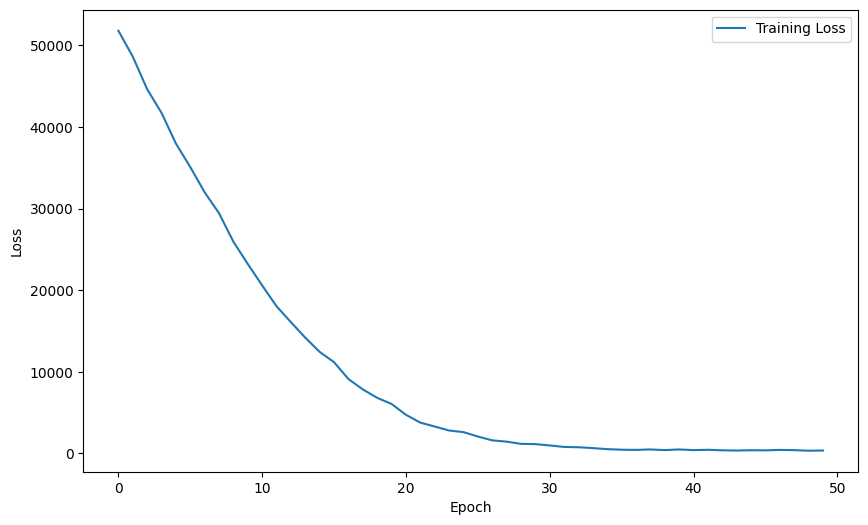

In [ ]:
desired_limit = 291
epoch_losses = []
epoch=50
for epoch in range(epoch):
    epoch_loss = 0.0
    for images, metadata, category_ids in train_dataloader:
        images = images.to(device)
        print(images.shape)
        metadata = metadata.to(device)
        category_ids = category_ids.to(device)
        outputs = model(images, metadata)
        loss = criterion(outputs, category_ids.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/5] - Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), f'{epoch}.pth')
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_losses = []
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
with torch.no_grad():
    for images, metadata, category_ids in test_dataloader:
        images = images.to(device)
        metadata = metadata.to(device)
        category_ids = category_ids.to(device)
        outputs = model(images, metadata)
        loss = criterion(outputs, category_ids.float())
        test_losses.append(loss.item())

average_test_loss = sum(test_losses) / len(test_losses)
print(f'Average Test Loss: {average_test_loss:.4f}')


Average Test Loss: 459.9446
